In [4]:
import re # using regular expression to find different seperators
from pyspark.sql.types import *
from pyspark.sql.functions import * # importing col

In [5]:
device_status ='s3://finalprojneil/devicestatus.txt'

In [6]:
device_status_log=sc.textFile(device_status)

# using regular expression to find the seperator
temp_var = device_status_log.map(lambda k: re.split('[,|_/]', k)) 

# Load data into dataframe and change the column names and select required data only
device_status_df = temp_var.toDF().select(col("_13").alias("latitude"), col("_14").alias("longitude"), col("_1").alias("Date"), col("_2").alias("Model"), col("_3").alias("Device ID"))

# device_status_df = device_status_df.withColumn("date", unix_timestamp(device_status_df["date"], "yyyy-mm-dd:HH:mm:ss").cast('timestamp'))
device_status_df = device_status_df.withColumn("Latitude", device_status_df["latitude"].cast('double'))
device_status_df = device_status_df.withColumn("Longitude", device_status_df["longitude"].cast('double'))

# filter latitude and longitude with 0 values
device_status_df = device_status_df.filter("Latitude != '0' or Longitude != '0' ")

# need to re look
# split model into manufacturer and model column
device_status_df = device_status_df.withColumn("Manufacturer", split(col("Model"), " ").getItem(0)).withColumn("Model", split(col("Model"), " ").getItem(1))

#caching df 
device_status_df.cache()

device_status_df.show(5)

[Stage 3:>                                                          (0 + 1) / 1]

+-------------+--------------+-------------------+-------+--------------------+------------+
|     Latitude|     Longitude|               Date|  Model|           Device ID|Manufacturer|
+-------------+--------------+-------------------+-------+--------------------+------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|   F41L|8cc3b47e-bd01-448...|    Sorrento|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|    1.0|ef8c7564-0a1a-465...|      MeeToo|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|    1.0|23eba027-b95a-472...|      MeeToo|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|   F41L|707daba1-5640-4d6...|    Sorrento|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Novelty|db66fe81-aa55-43b...|       Ronin|
+-------------+--------------+-------------------+-------+--------------------+------------+
only showing top 5 rows



In [7]:
device_status_df.coalesce(1).write.mode("overwrite").option("sep", ",").option("header","true").option("encoding", "UTF-8").csv("s3a://finalprojneil/updated_device_status")


In [8]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

def plot_data(df, a=0, after_prediction=False):
    pd_df = df.toPandas() # changing df to pandas dataframe
    gdf = geopandas.GeoDataFrame(pd_df, geometry=geopandas.points_from_xy(pd_df.Longitude, pd_df.Latitude))
    
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    if a == 1:
        ax = world.plot(figsize=(20, 12), edgecolor='black', cmap='GnBu')
    else:
        ax = world[world.name == 'United States of America'].plot(figsize=(10, 6), cmap='twilight', edgecolor='black')

    if after_prediction == False:
        gdf.plot(ax=ax, marker='.', color='red', markersize=15)
    else:
        gdf.plot(ax=ax, column='prediction',marker='.', markersize=15, categorical=True, legend=True)
        plt.scatter(centers.iloc[:,1],centers.iloc[:,0], marker="^", s=80, color='black')

    plt.show()

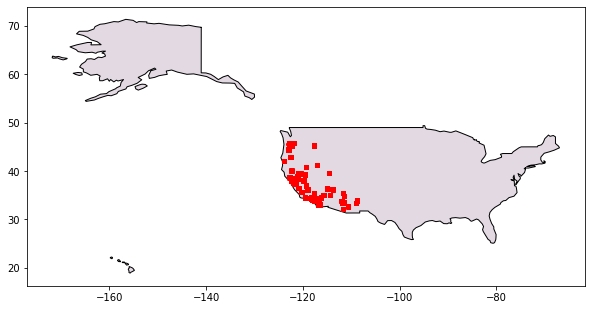

In [9]:
plot_data(device_status_df, a=0)